In [1]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import warnings
import pandas as pd
import numpy as np
from tabulate import tabulate
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import het_arch
import itertools
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Passagers_aeriens.xlsx to Passagers_aeriens.xlsx


In [3]:
data = pd.read_excel('Passagers_aeriens.xlsx')
data.head()

,Période,Nombre_passagers_aeriens
0,1994-01,3.067
1,1994-02,2.903
2,1994-03,3.607
3,1994-04,4.081
4,1994-05,4.360


In [4]:
data['Nombre_passagers_aeriens'].describe()

count    306.000000
mean       7.388843
std        2.631380
min        2.903000
25%        5.291750
50%        7.027000
75%        9.100750
max       14.577000
Name: Nombre_passagers_aeriens, dtype: float64

In [5]:
data.columns = ['Période', 'Nombre_passagers_aeriens']

data['Nombre_passagers_aeriens'] = pd.to_numeric(data['Nombre_passagers_aeriens'], errors='coerce')

data.dropna(inplace=True)

data.head(), data.tail()

(   Période  Nombre_passagers_aeriens
 0  1994-01                     3.067
 1  1994-02                     2.903
 2  1994-03                     3.607
 3  1994-04                     4.081
 4  1994-05                     4.360,
      Période  Nombre_passagers_aeriens
 301  2019-02                     9.130
 302  2019-03                    10.953
 303  2019-04                    12.791
 304  2019-05                    12.729
 305  2019-06                    13.793)

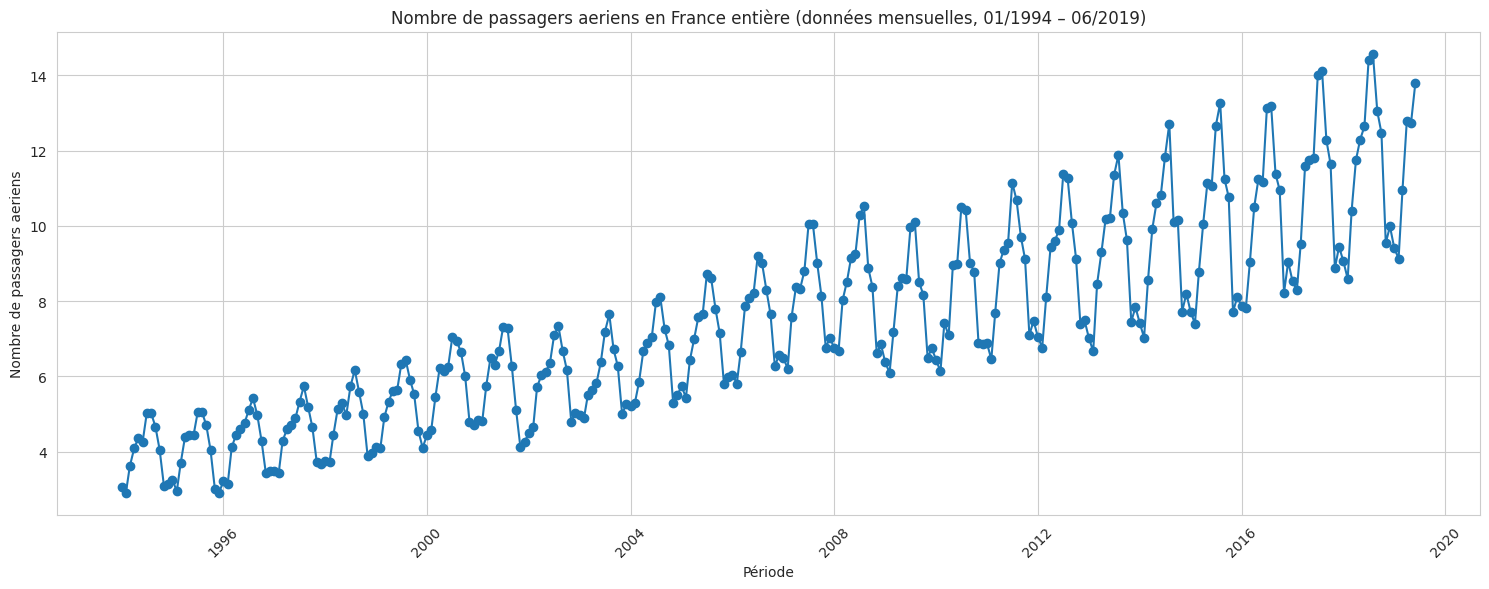

In [6]:
#Conversion de 'Period' de l'indice de période en datetime pour le tracé
sns.set_style("whitegrid")

def convert_period_to_date(period):
    if isinstance(period, str):
        year, month = period.split('-')
        return f"{year}-{month}-01"
    else:
        return period

data['Période'] = data['Période'].apply(convert_period_to_date)
data['Période'] = pd.to_datetime(data['Période'])

plt.figure(figsize=(15, 6))
plt.plot(data['Période'], data['Nombre_passagers_aeriens'], marker='o', linestyle='-')
plt.title('Nombre de passagers aeriens en France entière (données mensuelles, 01/1994 – 06/2019)')
plt.xlabel('Période')
plt.ylabel('Nombre de passagers aeriens')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

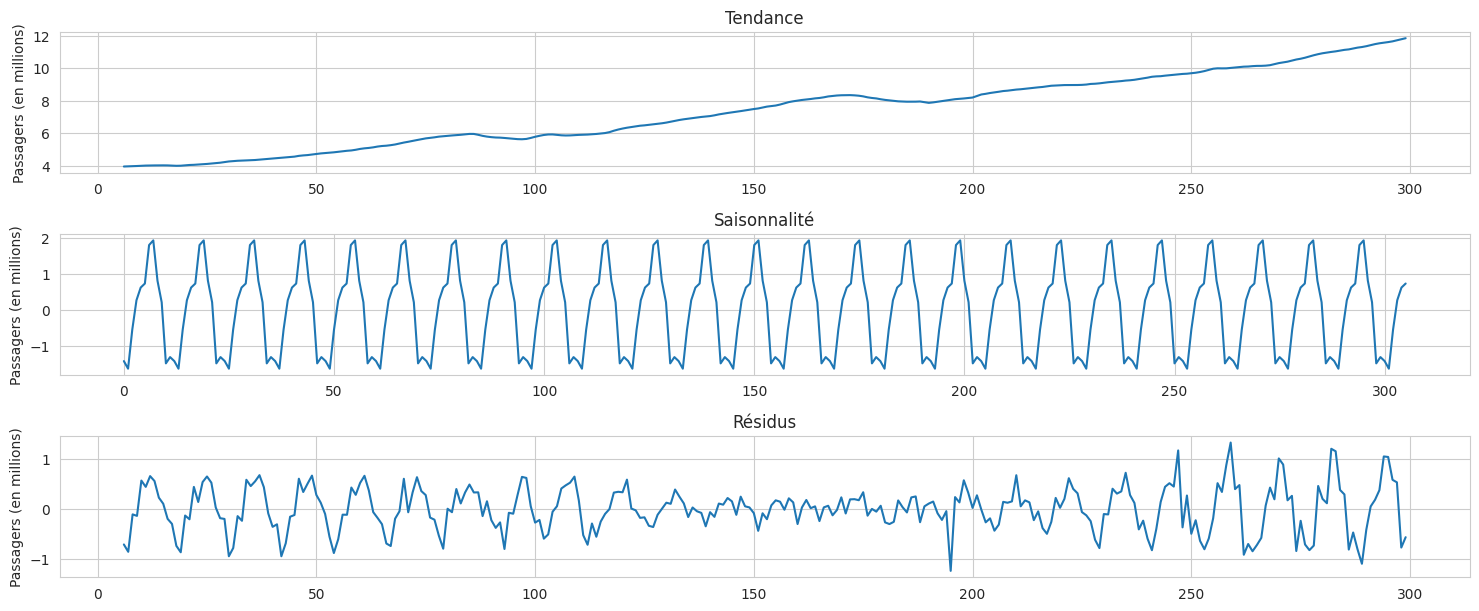

In [7]:
# Décomposition de la série temporelle
decomposition = seasonal_decompose(data['Nombre_passagers_aeriens'], model='additif', period=12)

plt.figure(figsize=(15, 8))

# Tendance
plt.subplot(411)
plt.plot(decomposition.trend)
plt.title('Tendance')
plt.ylabel('Passagers (en millions)')

# Saisonnalité
plt.subplot(412)
plt.plot(decomposition.seasonal)
plt.title('Saisonnalité')
plt.ylabel('Passagers (en millions)')

# Résidus
plt.subplot(413)
plt.plot(decomposition.resid)
plt.title('Résidus')
plt.ylabel('Passagers (en millions)')

plt.tight_layout()
plt.show()


In [8]:
# Test de Dickey-Fuller augmenté pour vérifier la stationnarité
result = adfuller(data['Nombre_passagers_aeriens'])

df_test_statistic = result[0]
df_p_value = result[1]
df_critical_values = result[4]

df_test_statistic, df_p_value, df_critical_values

(1.1156180895360284,
 0.9953477369700497,
 {'1%': -3.4530232710482367,
  '5%': -2.871523926671883,
  '10%': -2.5720897694878424})

In [9]:
data.dropna(subset=['Nombre_passagers_aeriens'], inplace=True)

# Calcul de l'évolution logarithmique du taux de chômage
data['Evolution_Nombre_passagers_aeriens'] = data['Nombre_passagers_aeriens'].diff(12)
#data['Log_Evolution_Nombre_passagers_aeriens'] = np.log(data['Nombre_passagers_aeriens']).diff()

data.head(), data.tail()

(     Période  Nombre_passagers_aeriens  Evolution_Nombre_passagers_aeriens
 0 1994-01-01                     3.067                                 NaN
 1 1994-02-01                     2.903                                 NaN
 2 1994-03-01                     3.607                                 NaN
 3 1994-04-01                     4.081                                 NaN
 4 1994-05-01                     4.360                                 NaN,
        Période  Nombre_passagers_aeriens  Evolution_Nombre_passagers_aeriens
 301 2019-02-01                     9.130                               0.537
 302 2019-03-01                    10.953                               0.552
 303 2019-04-01                    12.791                               1.043
 304 2019-05-01                    12.729                               0.436
 305 2019-06-01                    13.793                               1.146)

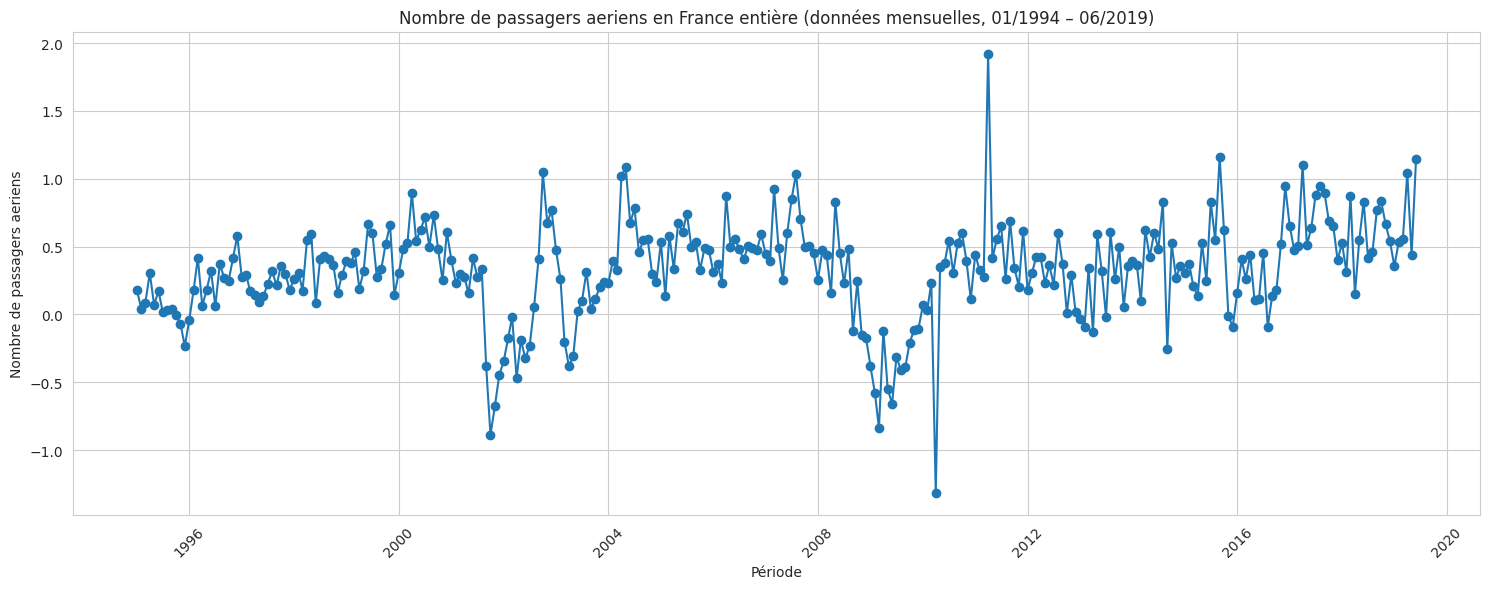

In [10]:
#Conversion de 'Period' de l'indice de période en datetime pour le tracé

sns.set_style("whitegrid")

def convert_period_to_date(period):
    if isinstance(period, str):
        year, month = period.split('-')
        return f"{year}-{month}-01"
    else:
        return period

data['Période'] = data['Période'].apply(convert_period_to_date)
data['Période'] = pd.to_datetime(data['Période'])

plt.figure(figsize=(15, 6))
plt.plot(data['Période'], data['Evolution_Nombre_passagers_aeriens'], marker='o', linestyle='-')
plt.title('Nombre de passagers aeriens en France entière (données mensuelles, 01/1994 – 06/2019)')
plt.xlabel('Période')
plt.ylabel('Nombre de passagers aeriens')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
data.dropna(subset=['Evolution_Nombre_passagers_aeriens'], inplace=True)

# Test de Dickey-Fuller augmenté pour vérifier la stationnarité
results = adfuller(data['Evolution_Nombre_passagers_aeriens'])

df_test_statistic = results[0]
df_p_value = results[1]
df_critical_values = results[4]

df_test_statistic, df_p_value, df_critical_values

(-3.2318554213210318,
 0.018213240262632577,
 {'1%': -3.4540935579190495,
  '5%': -2.8719934111688965,
  '10%': -2.5723401594120388})

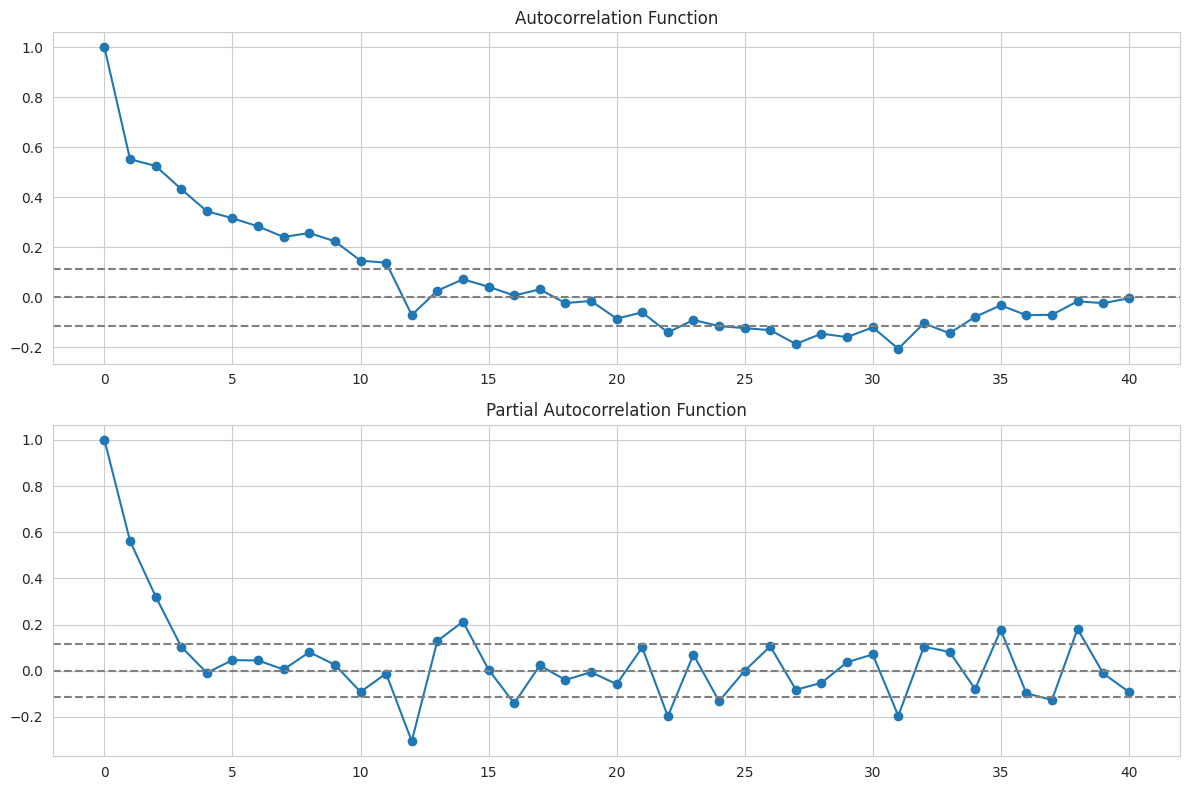

In [12]:
# l'ACF et PACF pour la série de l'évolution logarithmique
lags = 40  # Nombre de décalages à considérer pour ACF et PACF
acf_values = acf(data['Evolution_Nombre_passagers_aeriens'].dropna(), nlags=lags)
pacf_values = pacf(data['Evolution_Nombre_passagers_aeriens'].dropna(), nlags=lags, method='ols')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

ax1.plot(acf_values, marker='o')
ax1.axhline(y=0, linestyle='--', color='gray')
ax1.axhline(y=-1.96/np.sqrt(len(data['Evolution_Nombre_passagers_aeriens'].dropna())), linestyle='--', color='gray')
ax1.axhline(y=1.96/np.sqrt(len(data['Evolution_Nombre_passagers_aeriens'].dropna())), linestyle='--', color='gray')
ax1.set_title('Autocorrelation Function')

ax2.plot(pacf_values, marker='o')
ax2.axhline(y=0, linestyle='--', color='gray')
ax2.axhline(y=-1.96/np.sqrt(len(data['Evolution_Nombre_passagers_aeriens'].dropna())), linestyle='--', color='gray')
ax2.axhline(y=1.96/np.sqrt(len(data['Evolution_Nombre_passagers_aeriens'].dropna())), linestyle='--', color='gray')
ax2.set_title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()


In [13]:
# Test pour détecter l'effet ARCH dans la série différenciée logarithmiquement
arch_test_results = het_arch(data['Evolution_Nombre_passagers_aeriens'].dropna())
arch_test_results = pd.Series(arch_test_results[0:3], index=['Test Statistic', 'p-value', 'Lags'])

arch_test_results

Test Statistic    11.690893
p-value            0.306276
Lags               1.172055
dtype: float64

In [14]:
# Modèle SARIMAX(2, 1, 1)x(0, 1, [1, 2], 12)
model = SARIMAX(data['Nombre_passagers_aeriens'], order=(2, 1, 1), seasonal_order=(0, 1, [1, 2], 12))

model_fit = model.fit()

tables = model_fit.summary().tables

for table in tables:
    print(tabulate(table, headers="firstrow", tablefmt="grid"))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


+------------------+-------------------------------------+-------------------------+---------+
| Dep. Variable:   | Nombre_passagers_aeriens            |   No. Observations:     | 294     |
+==================+=====================================+=========================+=========+
| Model:           | SARIMAX(2, 1, 1)x(0, 1, [1, 2], 12) | Log Likelihood          | -32.030 |
+------------------+-------------------------------------+-------------------------+---------+
| Date:            | Sun, 10 Dec 2023                    | AIC                     | 76.060  |
+------------------+-------------------------------------+-------------------------+---------+
| Time:            | 20:50:05                            | BIC                     | 97.891  |
+------------------+-------------------------------------+-------------------------+---------+
| Sample:          | 0                                   | HQIC                    | 84.816  |
+------------------+------------------------------

In [15]:
# Suppression des avertissements pour les modèles qui ne convergent pas
warnings.filterwarnings("ignore")

# Définition des plages de paramètres à tester
p = d = q = range(0, 3)  # AR, I, MA
seasonal_pdq = [(x[0], 1, x[1], 12) for x in list(itertools.product(p, q))]  # Saison (P, D, Q, 12)

# Recherche du meilleur modèle SARIMA
best_aic = float("inf")
best_pdq = None
best_seasonal_pdq = None
best_model = None

for param in itertools.product(p, d, q):
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(data['Nombre_passagers_aeriens'],
                            order=param,
                            seasonal_order=param_seasonal,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_model = results
        except:
            continue

best_aic, best_pdq, best_seasonal_pdq, best_model.summary()

(77.363462884745,
 (2, 1, 1),
 (0, 1, 1, 12),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                      SARIMAX Results                                      
 Dep. Variable:           Nombre_passagers_aeriens   No. Observations:                  294
 Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 -33.682
 Date:                            Sun, 10 Dec 2023   AIC                             77.363
 Time:                                    20:56:11   BIC                             95.300
 Sample:                                         0   HQIC                            84.568
                                             - 294                                         
 Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 ar.L1  

In [16]:
# Prévision pour les 6 mois suivants (juillet à décembre 2019)
forecast_months = 6
forecast = model_fit.get_forecast(steps=forecast_months)
forecast_index = pd.date_range(data['Période'].iloc[-1] + pd.offsets.MonthBegin(), periods=forecast_months, freq='M')

forecast_conf_int = forecast.conf_int()

forecast_dfs = pd.DataFrame({
    'Forecast': forecast.predicted_mean,
    'Lower Confidence Interval': forecast_conf_int.iloc[:, 0],
    'Upper Confidence Interval': forecast_conf_int.iloc[:, 1]
})

forecast_dfs


,Forecast,Lower Confidence Interval,Upper Confidence Interval
294,15.183323,14.655328,15.711318
295,15.450149,14.876778,16.023519
296,13.682153,13.050295,14.314011
297,13.117986,12.455425,13.780546
298,10.260351,9.571221,10.949480
299,10.758870,10.049278,11.468463


In [17]:
# Prévision pour les 6 mois suivants (juillet à décembre 2019)
forecast = results.get_forecast(steps=6)

def convert_period_to_date(period):
    if isinstance(period, str):
        year, month = period.split('-')
        return f"{year}-{month}-01"
    else:
        return period

forecast_ci = forecast.conf_int()

forecast_df = pd.DataFrame({
    'Forecast': forecast.predicted_mean})
forecast_ic = pd.DataFrame({
    'Lower Confidence Interval': forecast_ci.iloc[:, 0],
    'Upper Confidence Interval': forecast_ci.iloc[:, 1]
})#, index=forecast_index)

forecast_df, forecast_ic

(      Forecast
 294  15.283459
 295  15.541002
 296  13.914556
 297  13.266052
 298  10.502298
 299  10.983429,
      Lower Confidence Interval  Upper Confidence Interval
 294                  14.721815                  15.845103
 295                  14.916332                  16.165671
 296                  13.189244                  14.639869
 297                  12.447771                  14.084333
 298                   9.617282                  11.387314
 299                  10.020503                  11.946354)

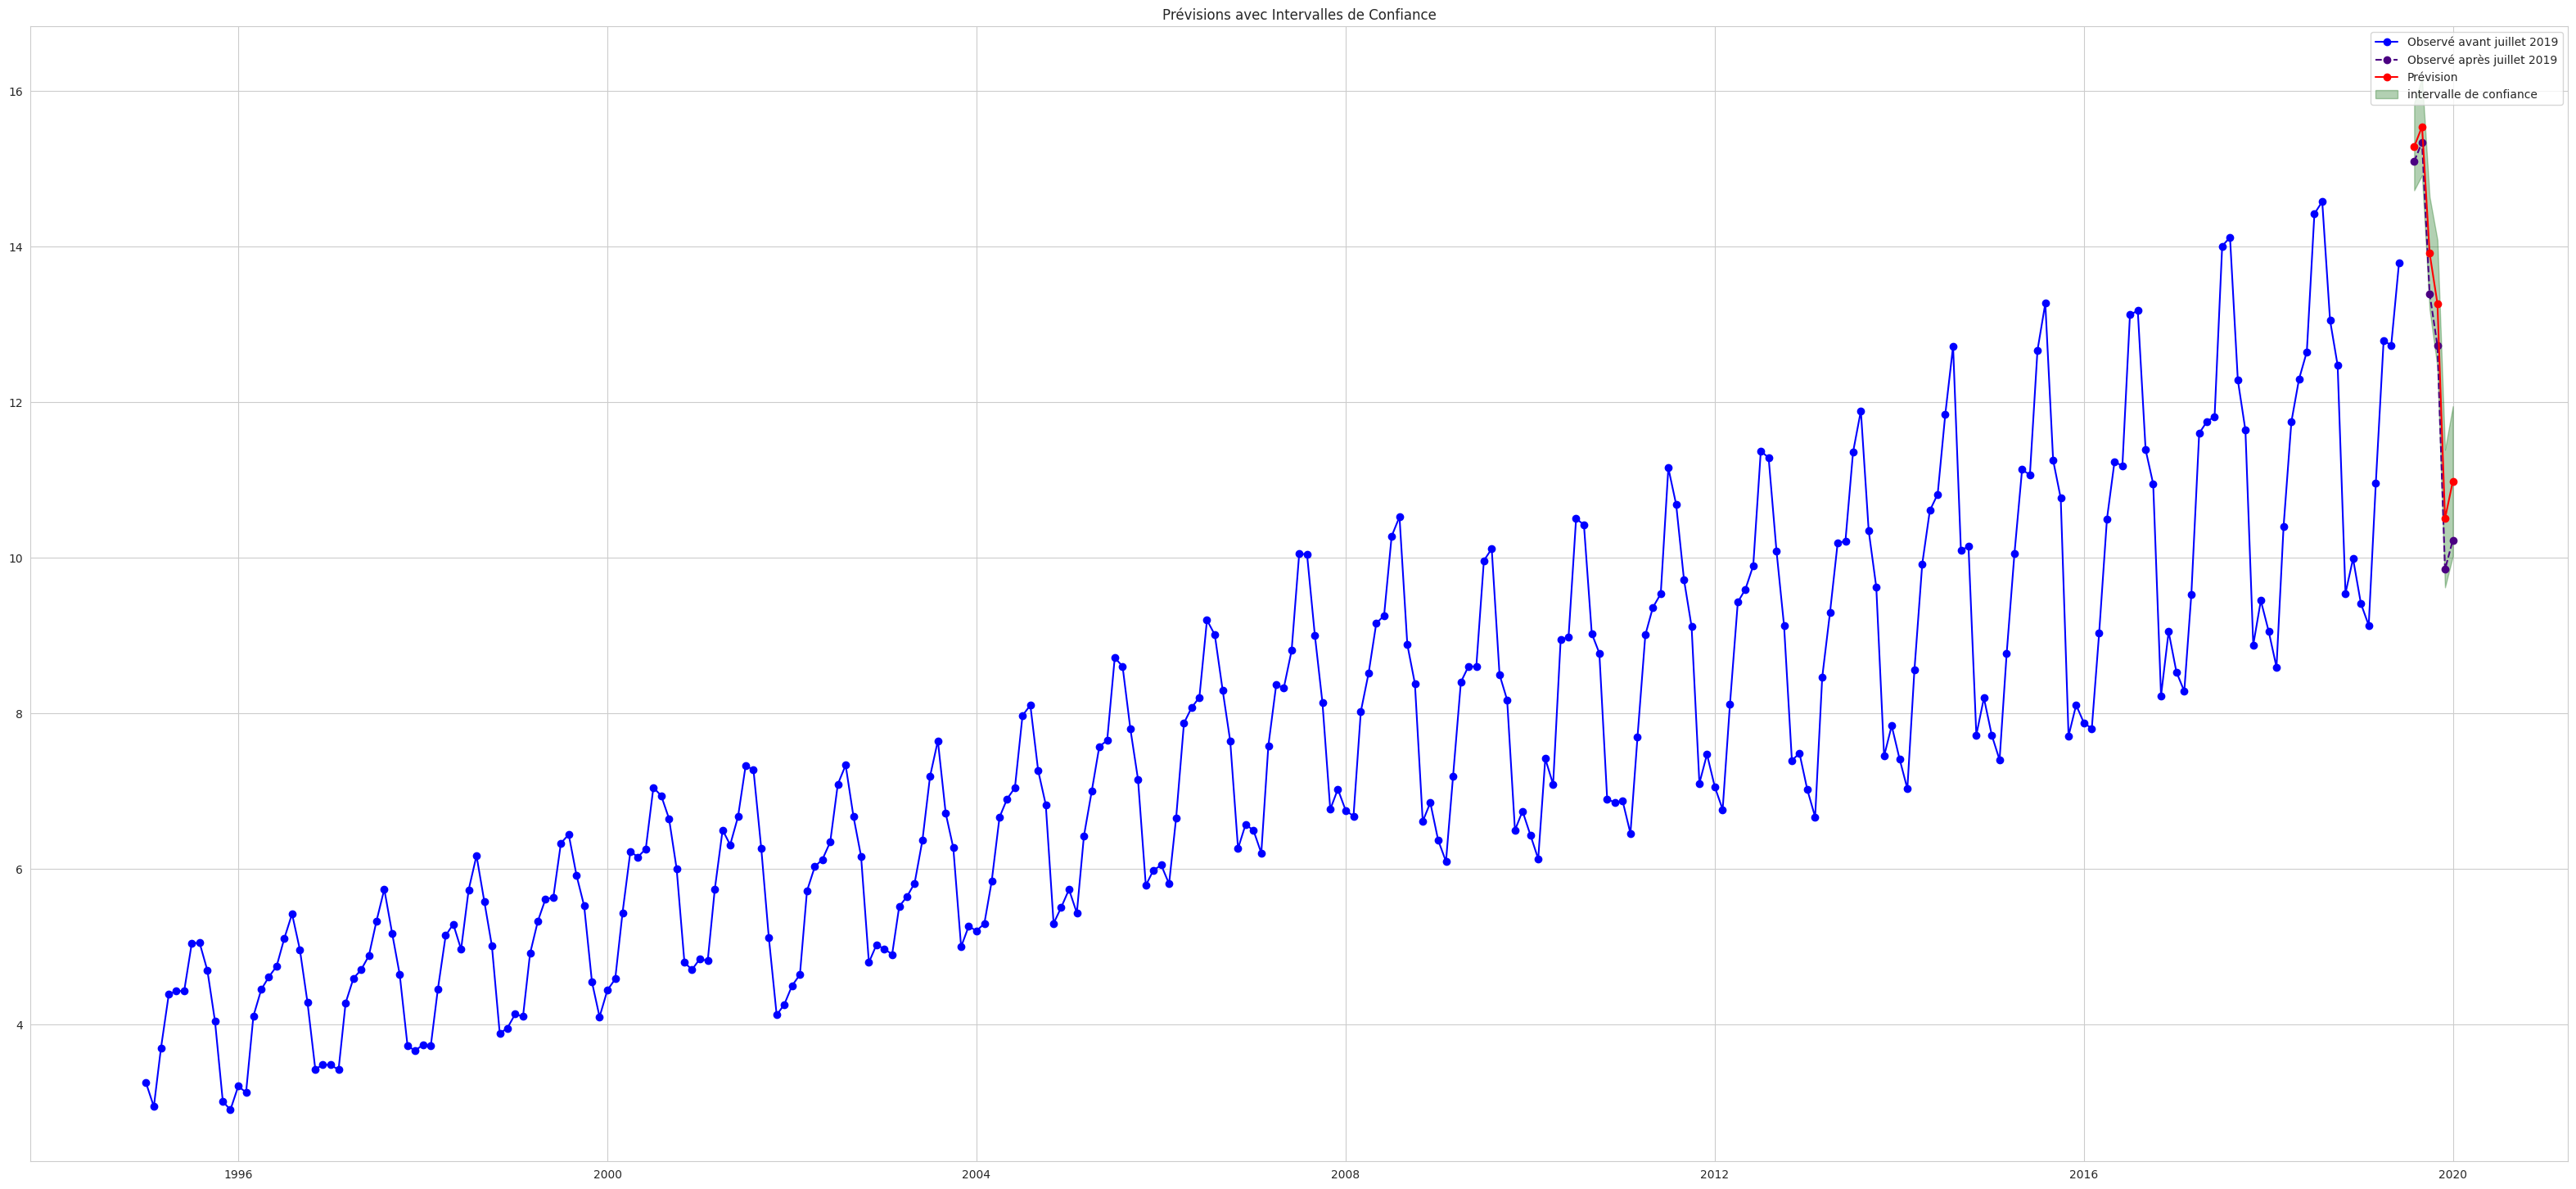

In [18]:

# Creation d'une série de dates pour la période de prévision
forecast_periods = forecast_index
forecast_dates = pd.to_datetime([convert_period_to_date(period) for period in forecast_periods])

# Ajustement les index de forecast_values et confidence_intervals
forecast_df.index = forecast_dates
forecast_ci.index = forecast_dates

# Nouvelles données observées
new_observed_values = [15.094, 15.341, 13.395, 12.724, 9.850, 10.226]
new_observed_dates = pd.to_datetime([convert_period_to_date(period) for period in forecast_periods[:len(new_observed_values)]])

# Création d'une série Pandas pour les nouvelles données observées
new_observed_series = pd.Series(new_observed_values, index=new_observed_dates)



# Affichage des données observées et des prévisions
plt.figure(figsize=(40, 18))
plt.plot(data['Période'], data['Nombre_passagers_aeriens'], label='Observé avant juillet 2019', color='blue',  marker='o')
plt.plot(new_observed_series.index, new_observed_series, label='Observé après juillet 2019', color='indigo', marker='o', linestyle='dashed')
plt.plot(forecast_df.index, forecast_df, label='Prévision', color='red',  marker='o')

# Ajout des intervalles de confiance
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],  # Borne inférieure de l'intervalle
                 forecast_ci.iloc[:, 1],  # Borne supérieure de l'intervalle
                 label='intervalle de confiance', color='darkgreen', alpha=0.3)  # 'alpha' contrôle la transparence

plt.title('Prévisions avec Intervalles de Confiance')
plt.legend()
plt.show()

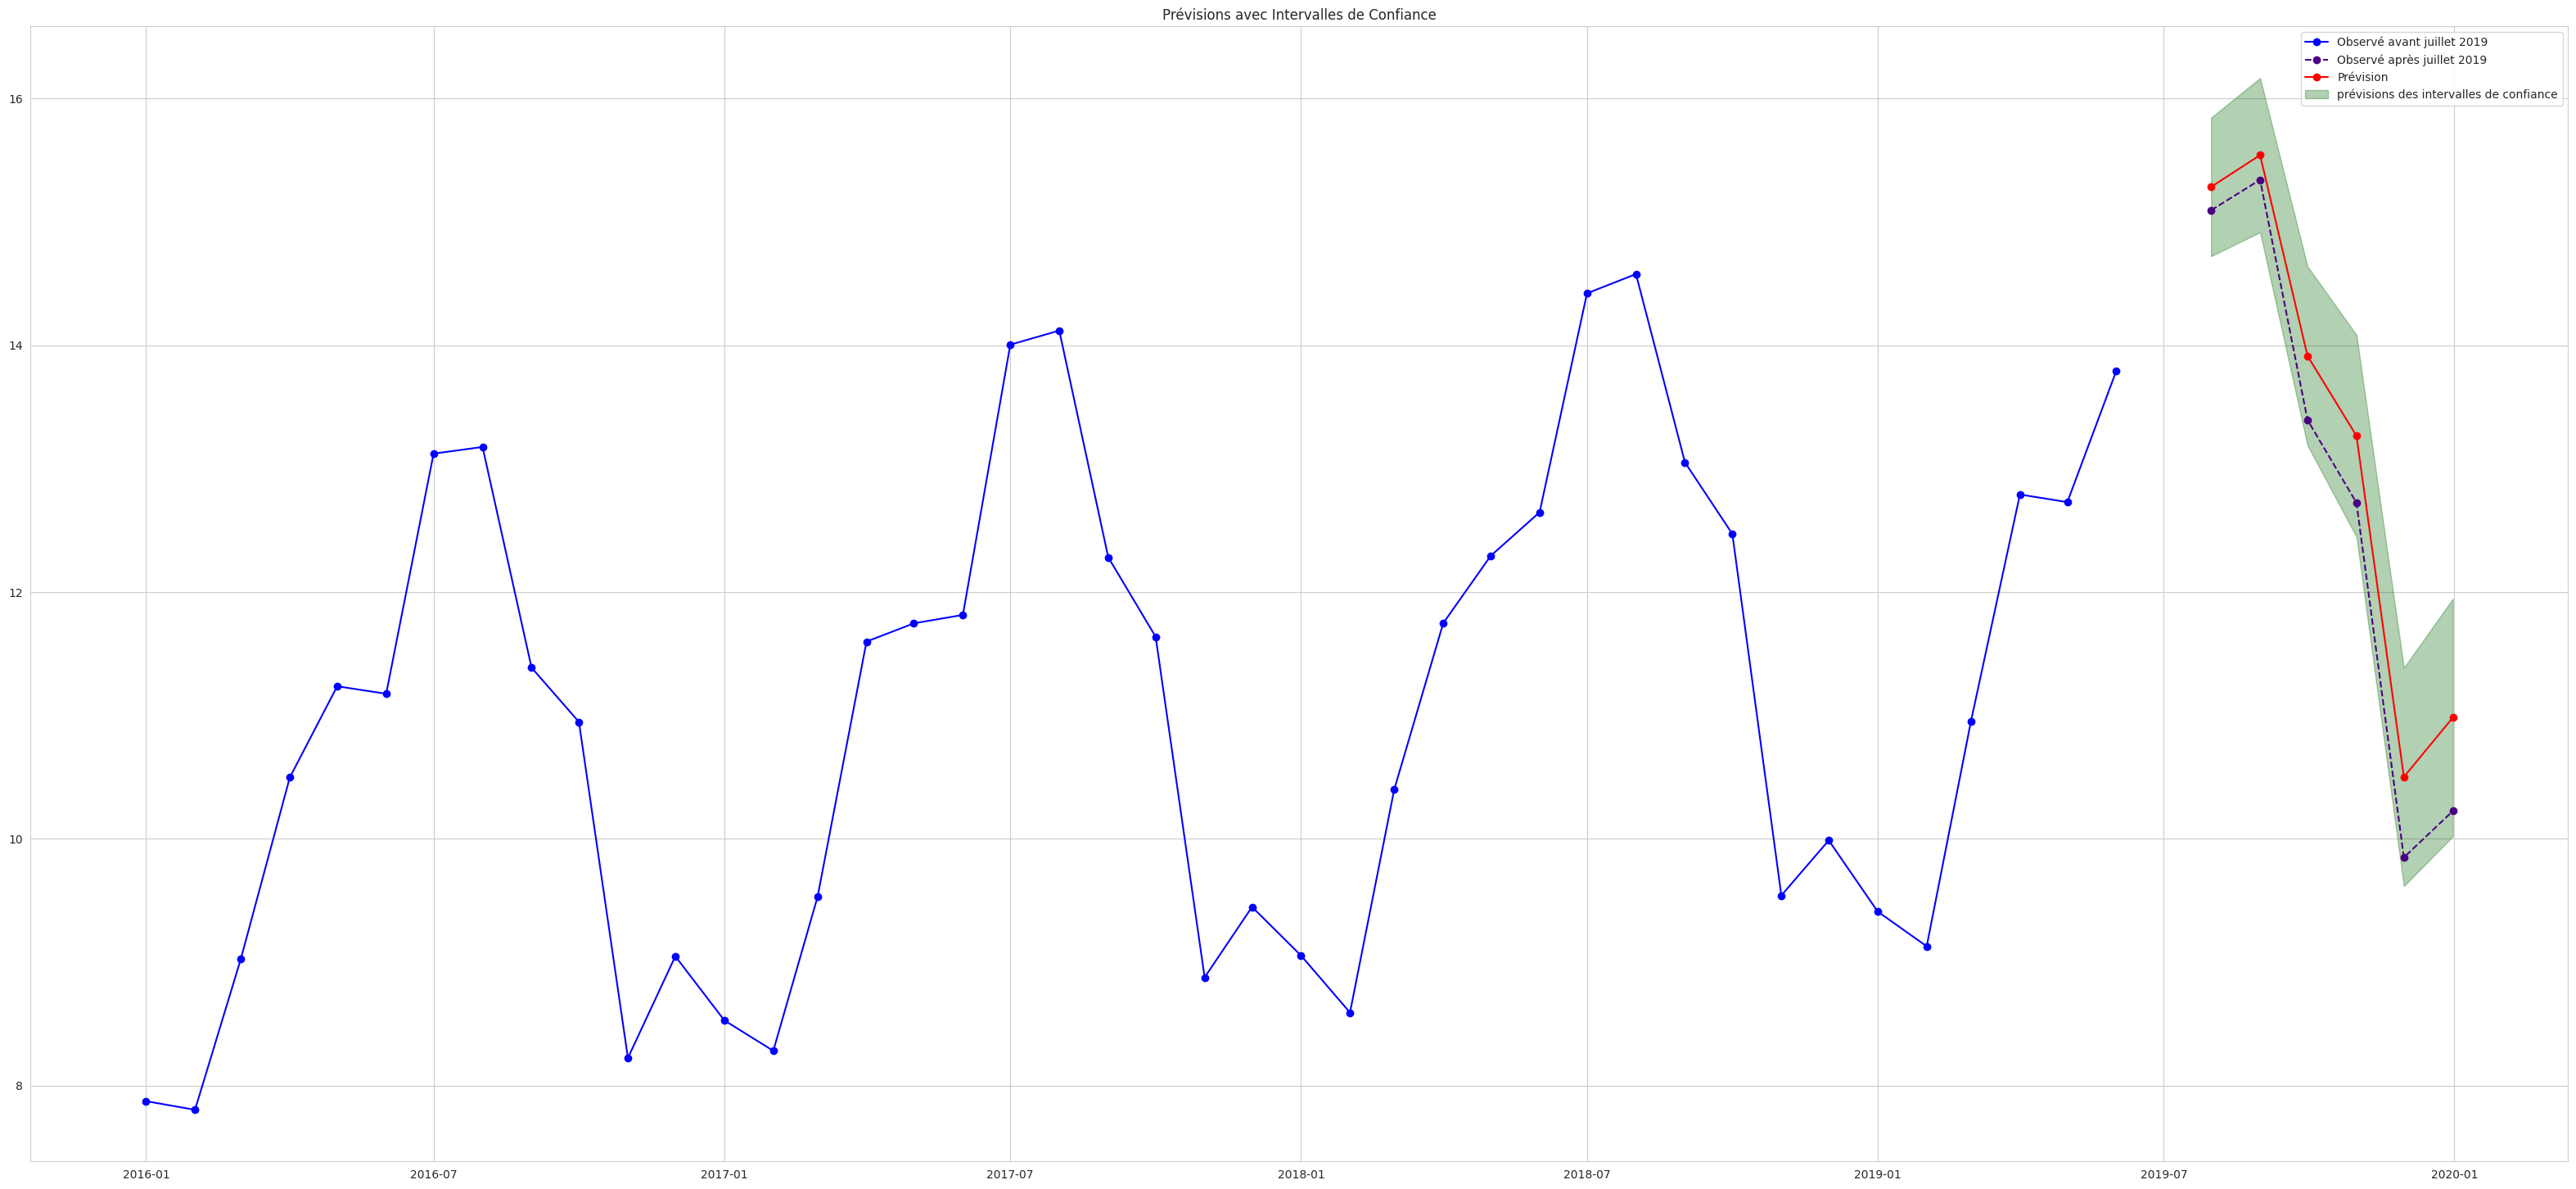

In [19]:
# Filtrer les données pour ne conserver que celles après 2016
data_filtered = data[pd.to_datetime(data['Période']) >= pd.Timestamp('2016-01-01')]

# Nouvelles données observées
new_observed_values = [15.094, 15.341, 13.395, 12.724, 9.850, 10.226]
new_observed_dates = pd.to_datetime([convert_period_to_date(period) for period in forecast_periods[:len(new_observed_values)]])
new_observed_series = pd.Series(new_observed_values, index=new_observed_dates)

# Affichage des données
plt.figure(figsize=(40, 18))
plt.plot(data_filtered['Période'], data_filtered['Nombre_passagers_aeriens'], label='Observé avant juillet 2019', color='blue', marker='o')
plt.plot(new_observed_series.index, new_observed_series, label='Observé après juillet 2019', color='indigo', marker='o', linestyle='dashed')
plt.plot(forecast_df.index, forecast_df, label='Prévision', color='red', marker='o')

# Ajout des intervalles de confiance
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],  # Borne inférieure
                 forecast_ci.iloc[:, 1],  # Borne supérieure
                 label='prévisions des intervalles de confiance', color='darkgreen', alpha=0.3)

plt.title('Prévisions avec Intervalles de Confiance')
plt.legend()
plt.show()

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [21]:
common_dates = new_observed_series.index.intersection(forecast_df.index)
observed = new_observed_series[common_dates]
predicted = forecast_df.loc[common_dates]

# Calcul des métriques
mse = mean_squared_error(observed, predicted)
mae = mean_absolute_error(observed, predicted)
r2 = r2_score(observed, predicted)

print("Erreur quadratique moyenne (MSE):", mse)
print("Erreur absolue moyenne (MAE):", mae)
print("Coefficient de détermination (R^2):", r2)


Erreur quadratique moyenne (MSE): 0.27314080691704135
Erreur absolue moyenne (MAE): 0.4767991840913724
Coefficient de détermination (R^2): 0.9401926787678732
